In [1]:
from gekko import GEKKO
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 500', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 10', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 50', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']

# Initialize variables
x1 = m.Var(value=1,lb=1,ub=5)
x2 = m.Var(value=5,lb=1,ub=5)
# Integer constraints for x3 and x4
x3 = m.Var(value=5,lb=1,ub=5,integer=True)
x4 = m.Var(value=1,lb=1,ub=5,integer=True)
# Equations
m.Equation(x1*x2*x3*x4>=25)
m.Equation(x1**2+x2**2+x3**2+x4**2==40)
m.Obj(x1*x4*(x1+x2+x3)+x3) # Objective
m.solve(disp=False) # Solve
print('Results')
print('x1: ' + str(x1.value))
print('x2: ' + str(x2.value))
print('x3: ' + str(x3.value))
print('x4: ' + str(x4.value))
print('Objective: ' + str(m.options.objfcnval))

Results
x1: [1.3589086474]
x2: [4.5992789966]
x3: [4.0]
x4: [1.0]
Objective: 17.532267301


In [33]:
class MyAgent:
    def __init__(self):
        ...
    
    def best_action(self, state):
        action = {}
        action['mach_number'] = 0.77
        action['altitude'] = 609.6
        action['trajectory'] = 2
        return action

In [34]:
from aircraft_env import Location
from aircraft_env import AircraftEnv
from utils.env_extra import env_summary
%load_ext autoreload
%autoreload 2
loc_1 = Location(45.46873715, -73.74257166095532)
loc_2 = Location(49.0068908, 2.5710819691019156)
agent = MyAgent()
env = AircraftEnv(arrival_location=loc_1, destination=loc_2, n_waypoints=9)

n = env.n_waypoints - 1
df = env_summary(env, agent)
df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,trajectory,waypoint,speed,tas,distance,wind_magnitude,wind_direction,course,correction_angle,altitude,time_for_distance,fuel_burn,total_time,reward,fuel_flow
0,2,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
1,2,1,232.336932,228.530242,692678.38798,3.930965,71.027558,56.703470,-0.243832,10609.6,2981.352915,1149.086624,2981.352915,-1149.086624,0.3854245562990019
2,2,2,226.085326,227.203510,692678.38798,5.769508,322.006729,62.465560,1.430920,11219.2,3063.791893,1121.573065,6045.144808,-1121.573065,0.3660735142535916
3,2,3,219.773306,227.203510,692678.38798,30.412114,328.880007,69.206522,7.567026,11828.8,3151.785814,1099.454617,9196.930622,-1099.454617,0.3488354482125041
4,2,4,219.463490,227.203510,692678.38798,39.637985,173.071102,76.847750,-9.987432,12438.4,3156.235179,1053.568182,12353.165801,-1053.568182,0.3338053479479078
5,2,5,196.130085,227.203510,692678.38798,44.530055,214.909090,85.149776,-8.665549,13048.0,3531.729395,1133.629924,15884.895195,-1133.629924,0.32098436690170556
6,2,6,201.430390,227.203510,692678.38798,26.444102,287.467590,93.716501,1.585364,13657.6,3438.797822,1067.346590,19323.693017,-1067.346590,0.3103836413262666
7,2,7,222.071661,227.203510,692678.38798,8.700504,227.323299,102.079322,-1.792200,14267.2,3119.166059,942.068590,22442.859076,-942.068590,0.3020257890797795
8,2,8,244.580755,227.203510,692678.38798,18.291803,127.339210,109.825991,-1.388245,14876.8,2832.105039,838.151336,25274.964115,-838.151336,0.2959464160396258


In [35]:
df['fuel_burn'].sum()

8404.878928710928

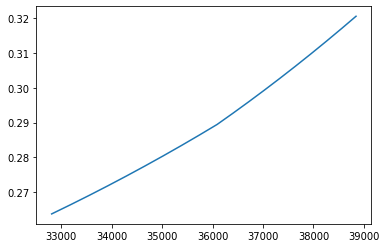

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils.units_converter import meter2feet
tas=200
altitude=meter2feet(np.linspace(env.cruise_alt_min, env.cruise_alt_max, 1000))

FF = env.aicraft.fuel_enroute(30000, tas, altitude, path_angle=0)
plt.plot(altitude, FF)

In [94]:
def aicraft_problem(x):
    env.reset()
    i = 0
    n = env.n_waypoints - 1
    
    for i in range(n):
        
        action = {}
        
        action['trajectory'] = int(np.round(x[n + 5*n + i]))
        ai = n + 5*i
        action['mach_number'] = x[i]
        if np.round(x[ai]) + np.round(x[ai+ 1]) + np.round(x[ai+2]) + np.round(x[ai+3]) + np.round(x[ai+4]) != 1:
            return 100000
        action['altitude'] = 0. * np.round(x[ai]) +  609.6 * np.round(x[ai + 1]) - 304.8 * \
                            np.round(x[ai + 2]) - 609.6 * \
                            np.round(x[ai + 3]) + 304.8 * np.round(x[ai + 4])
        
#         print(action)
        state, reward, done = env.step(action)
#         print(reward)
        if i == 0:
            f = reward
        else:
            f += reward
    return -f    
 

In [84]:
from scipy.optimize import NonlinearConstraint, LinearConstraint
nlcs = []
for i in range(n):
    ai = n + 5*i
    constr_f = lambda x: np.round(x[ai]) + np.round(x[ai+ 1]) + np.round(x[ai+2]) + np.round(x[ai+3]) + np.round(x[ai+4])
    nlc = NonlinearConstraint(constr_f, 0.9, 1.1)
    nlcs.append(nlc)


# the sum of x[0] and x[1] must be less than 1.9


In [81]:
for i in range(n):
    ai = n + 5*i
    k = lambda x: np.sum(np.array([np.round(x[ai + j]) for j in range(5)]))
    print(k(result.x))
#     constr_f = lambda x: 
#     nlc = NonlinearConstraint(constr_f, 0.999, 1.)
#     nlcs.append(nlc)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [89]:
lower_x = [0 for _ in range(5*n)]
lower_x[::5] = [1 for _ in range(len(lower_x[::5]))]

lower_x2 = [0 for _ in range(5*n)]
lower_x2[::5] = [1 for _ in range(len(lower_x[::5]))]
mach_numbers = [
    (env.cruise_mach_range[0], env.cruise_mach_range[-1]) for _ in range(n)
]
altitude = [
    (0, 1) for i in range(5*n)
]

In [95]:
from scipy.optimize import differential_evolution
import numpy as np

bounds = mach_numbers + altitude + [(0, 4) for _ in range(n)]
result = differential_evolution(aicraft_problem, bounds,x0= np.array([env.cruise_mach_range[0] for _ in range(n)] + \
                                                            lower_x + [2 for _ in range(n)]), polish=False,
                                seed=42, updating='deferred', workers=6)
result.x, result.fun

(array([0.75042658, 0.75036328, 0.75052659, 0.75280804, 0.75878981,
        0.77906847, 0.78054809, 0.77267815, 0.29391425, 0.77601095,
        0.35808349, 0.27270584, 0.20733724, 0.06833331, 0.79429565,
        0.18591056, 0.42777243, 0.03666398, 0.18532422, 0.77411667,
        0.38042842, 0.26867561, 0.01904694, 0.16581939, 0.66776171,
        0.16771002, 0.28195381, 0.25045792, 0.05198048, 0.70412561,
        0.28999063, 0.3775863 , 0.22673411, 0.21031124, 0.91308349,
        0.45810842, 0.34013262, 0.20907587, 0.12105133, 0.79552949,
        0.25282752, 0.34458712, 0.46959938, 0.1643903 , 0.18457293,
        0.27889615, 0.2921354 , 0.78605995, 2.44478784, 0.92624048,
        0.18659197, 0.44046456, 1.10138508, 0.36673886, 0.25849519,
        2.66805317]),
 8098.396872279835)

In [107]:
class SolverAgent:
    def __init__(self, x):
        self.x = x
    
    def best_action(self, state):
        x = self.x
        i = state['waypoint']
        action = {}
        action['trajectory'] = int(np.round(x[n + 5*n + i]))
        ai = n + 5*i
        action['mach_number'] = x[i]
        action['altitude'] = 0. * np.round(x[ai]) +  609.6 * np.round(x[ai + 1]) - 304.8 * \
                            np.round(x[ai + 2]) - 609.6 * \
                            np.round(x[ai + 3]) + 304.8 * np.round(x[ai + 4])
        return action
agent = SolverAgent(result.x)      

In [109]:
df = env_summary(env, agent)
df

,trajectory,waypoint,speed,tas,distance,wind_magnitude,wind_direction,course,correction_angle,altitude,time_for_distance,fuel_burn,total_time,reward,fuel_flow
0,2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0
1,2,1,226.527632,222.720997,692678.387980,3.930965,71.027558,56.703470,-0.250192,10609.6,3057.809690,1133.619248,3057.809690,-1133.619248,0.3707291698542563
2,1,2,220.699654,221.409314,694429.134740,5.769508,322.006729,58.329457,1.484104,11219.2,3146.489462,1110.059094,6204.299152,-1110.059094,0.3527928847074875
3,0,3,219.008077,221.457500,694421.546201,13.545263,326.163992,64.844214,3.466423,11828.8,3170.757700,1068.796803,9375.056852,-1068.796803,0.33707930521175067
4,0,4,219.725188,222.130686,692627.408837,37.808945,165.255611,76.520012,-9.797640,12438.4,3152.244017,1023.276740,12527.300869,-1023.276740,0.3246185050976279
5,1,5,218.095719,223.895724,694457.953821,35.106116,184.117391,89.130542,-8.986584,13048.0,3184.188843,1005.326552,15711.489712,-1005.326552,0.3157245383521668
6,0,6,211.056212,229.879340,694472.198170,19.104725,279.880104,89.596415,0.850103,13657.6,3290.460823,1033.715351,19001.950534,-1033.715351,0.31415519177131396
7,0,7,236.429459,230.315929,789611.989489,15.899425,172.685200,107.089034,-3.604300,14267.2,3339.736062,1020.991506,22341.686596,-1020.991506,0.3057102378669202
8,3,8,255.516498,227.993750,599373.980373,27.839582,122.362339,114.192916,-0.994215,14572.0,2345.734957,702.611578,24687.421552,-702.611578,0.29952726605680746


In [110]:
df['fuel_burn'].sum()

8098.396872279836

In [97]:
np.round(result.x[n:])

array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0., 3.])

In [9]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

xm = np.array([[1, 2, 3], [1, 2, 3]]).T
print(xm.shape)
ym = np.array([0.1,0.2,0.3])

m = GEKKO()             # create GEKKO model
m.options.IMODE = 2     # solution mode
x = m.Param(value=np.array([[1, 2, 3], [1, 2, 3]]).T) # prediction points
y = m.Var()             # prediction results
m.cspline(x, y, xm, ym) # cubic spline
m.solve(disp=False)     # solve

# create plot
# plt.plot(altitude,FF,'bo')
# plt.plot(x.value,y.value,'r--',label='cubic spline')
# plt.legend(loc='best')

(3, 2)


Exception: Data arrays must have the same length

In [ ]:
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 500', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 10', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 50', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']

mach_numbers = [
    m.Var(value=env.cruise_mach_range[0], lb=env.cruise_mach_range[0], ub=env.cruise_mach_range[-1]) for _ in range(n)
]

lower_x = [0 for _ in range(5*n)]
lower_x[::5] = [1 for _ in range(len(lower_x[::5]))]
altitude = [
    m.Var(value=lower_x[i], lb=0, ub=1, integer=True) for i in range(5*n)
]
# problem['xl'] = [env.cruise_mach_range[0] for _ in range(n)] + [0 for _ in range(5*n)]
# problem['xu'] = [env.cruise_mach_range[-1] for _ in range(n)] + [1 for _ in range(5*n)]

In [ ]:

def aicraft_problem(mach_numbers, altitude):
    env.reset()
    i = 0
    n = env.n_waypoints - 1
    
    for i in range(n):
        
        action = {}
        action['trajectory'] = 2
        ai = 5*i
        action['mach_number'] = mach_numbers[i]
        action['altitude'] = 0 * altitude[ai] +  609.6 * altitude[ai + 1] - 304.8 * altitude[ai + 2] - 609.6 * \
                            altitude[ai + 3] + 304.8 * altitude[ai + 4]
        
#         print(action)
        state, reward = env.solver_step(action, m)
#         print(reward)
        if i == 0:
            f = reward
        else:
            f += reward
    return f    

f = aicraft_problem(mach_numbers, altitude)  
m.Obj(f)

In [ ]:
m.solve()

In [ ]:
from utils.env_extra import env_summary

df = env_summary(env)
df